# Introduction

# The Bayesian Approach to the Simple Linear Model (SLR) and Multi-Linear Regression (MLR)

So although the basic idea of Bayesian regressions is not much different from what you saw when doing linear regressions. There will be a major difference in how they are implemented in code. Whereas one simply pushed in columns of data and a target into a regression to get output, the actual "specification" of the model is a bit more involved in the Bayesian variety. In particular, you will have to specify priors, likelihoods etc. However, fear not, we are not going to write any of these posterior distributions and their associated ingredients manually. We're going to introduce a dedicated software packages this week, PyStan, that not only gives you leverage in the specification side, but includes a whole lot of really efficient C++ code to do the parameter estimation. Unlike what you did earlier in the week, we won't use MLE to estimate the parameters utilizing the Monte-Carlo Markov Chain (MCMC). 

Although this topic is in itself not the point of our lecture, it will be a tool we leverage over-and-over again to estimate our models. For those of you who are interested in reading more, check out the following link: 

- Hardcore primer (requires Calculus, and strong mathematical maturity: http://www4.stat.ncsu.edu/~sghosh/TEACHING/st790/lectures/GillMCMC.pdf
- Not as Hardcore: http://statwww.epfl.ch/teaching/3eCycleRomand/printemps-2005/EG.lectures.villars05.pdf

Sorry, there's just no way around a lot of mathematics when dealing with MCMC. 


# Bayesian Regression vs Classical Regressions


Getting back to our previous discussion, the difference between classical and Bayesian regression can be thought of as thus: 
-   Classical regression is a special case of the Bayesian perspective whereby we have a non-informative prior. 

I'm sure you recall what 'non-informative' refers to uniform priors (i.e. no prior information assumed to bias things one way or another). 

The Bayesian approach also relaxes a few assumptions, we no longer have to assume homoscedasticity etc. 

(Just in case you need to review this homoskedasticity: https://www.youtube.com/watch?v=zRklTsY9w9c).

You can remember what it means by just breaking the word down to it's component parts - homo : same, skedastic : variation, the later word can be thought of as being related to "skew" i.e. how much your line "skews" from the "true" trend-line.

However, as previously stated, the Bayesian approach is fundamentally the "inverse" trick (i.e f(X|$\theta$) to f($\theta$|X)), and is primarily concerned with estimating parameters. In the case of Regressions, estimating $\beta$'s and estimating $\sigma$'s (and thus $\sigma^2$'s).

Why does this matter? Bayesian regressions give you, the modeler/data scientist a lot more control over your model. You can specify priors for each of the parameters in your regression (the $\beta$'s), the error term, and even the constant (as well as the target). Therefore, it's worth to learn, and will give you more latitude to fit your model to the data you 

So we know that the joint of $\beta$ and $\sigma^2$ is proportional to the precision, defined as $\frac{1}{\sigma^2}$. Further, $$p(\beta, \sigma^2|{y}) = p(\beta|{y}, \sigma^2)p(\sigma^2|{y})$$

As we mentioned previously, we have check that this is not a pathological probability (proper) blah blah, but this ins't a mathematics course, so we'll again be blissfully ignorant of these complexities. 

If we had a procedural step-wise perspective of the procedure, here's what it would be: 

1. Determine $\beta$, $\sigma$ using posterior distributions
2. Construct $y_{i+1}, y_{i+2}, ... y_{i+n}$ from a distribution using the parameters from step 1

#### Problem 2 - Loading Data and running a pymc Linear Regression

Today we're going to be studying a standard UCI Machine Learning data (an oldie but a goodie as they say), https://archive.ics.uci.edu/ml/datasets/Housing

The data contains information that are possibly related to housing values in the Boston suburb (think Zip Realty -maybe not). Here's a brief summary of the data found on the website: 

    - CRIM      per capita crime rate by town
    - ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    - INDUS     proportion of non-retail business acres per town
    - CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    - NOX       nitric oxides concentration (parts per 10 million)
    - RM        average number of rooms per dwelling
    - AGE       proportion of owner-occupied units built prior to 1940
    - DIS       weighted distances to five Boston employment centres
    - RAD       index of accessibility to radial highways
    - TAX       full-value property-tax rate per 10,000 USD
    - PTRATIO   pupil-teacher ratio by town
    - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    - LSTAT    % lower status of the population
    - MEDV     Median value of owner-occupied homes in 1000 USDs


Load the data and list the first 5 observations to get a feel for the data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Load the data

housing = pd.read_csv('../../DSI-CHI-1/lessons/week-08/2.2-linear-regression-with-bayes/assets/datasets/housing.csv', index_col=0)
housing.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


We're going to use a library to handle a lot of the interior math known as PyMC. Particularly we want the version 3 of this library (it's still in release candidate form). Run `conda install -c conda-forge pymc3` on your command line to install pymc3

In [2]:
import pymc3 as pm

PyMC requires that we use a `with` construction to fit our model like so:

In [11]:
housing_dict = dict(MEDV=housing['MEDV'].values, 
                    CRIM=housing['CRIM'].values,
                    NOX=housing['NOX'].values,
                    LSTAT=housing['LSTAT'].values)

with pm.Model() as model:
    pm.glm.glm('MEDV ~ CRIM + NOX + LSTAT', housing_dict)
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(2000, step, progressbar=True) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [00:03<00:00, 546.86it/s]


So, the graph on the left looks at the marginal posterior probability and the right graph shows the iteration over the samples (also known as a trace plot)

This is a diagnostic tool to understand how well our "mixing" is occuring while implementing the MCMC estimation. In general we want our traceplots to be devoid of 'jump' (see picture below - thanks Harvard: http://www.people.fas.harvard.edu/~plam/teaching/methods/convergence/convergence_print.pdf)



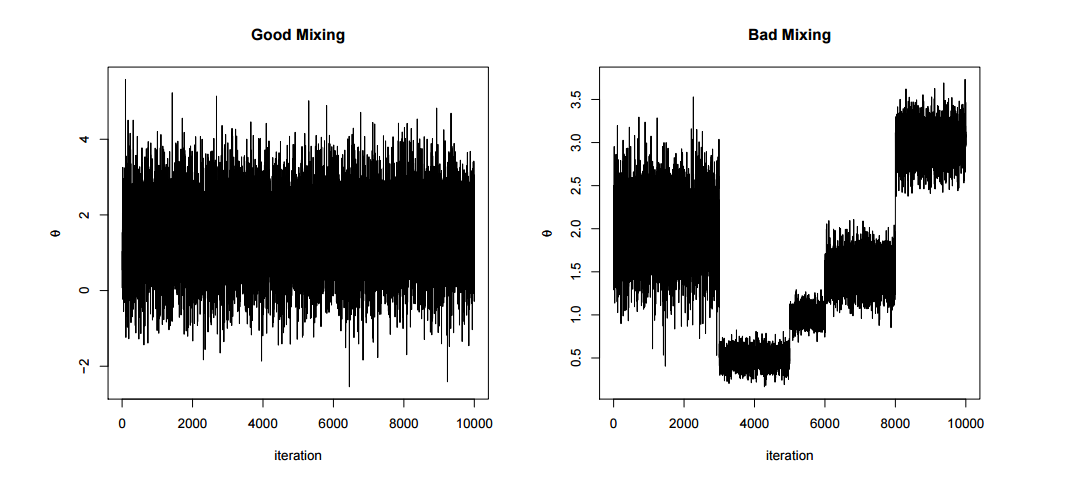

In [12]:
from IPython.display import Image
Image('../../DSI-CHI-1/lessons/week-08/2.2-linear-regression-with-bayes/assets/images/traceplot examples.PNG')

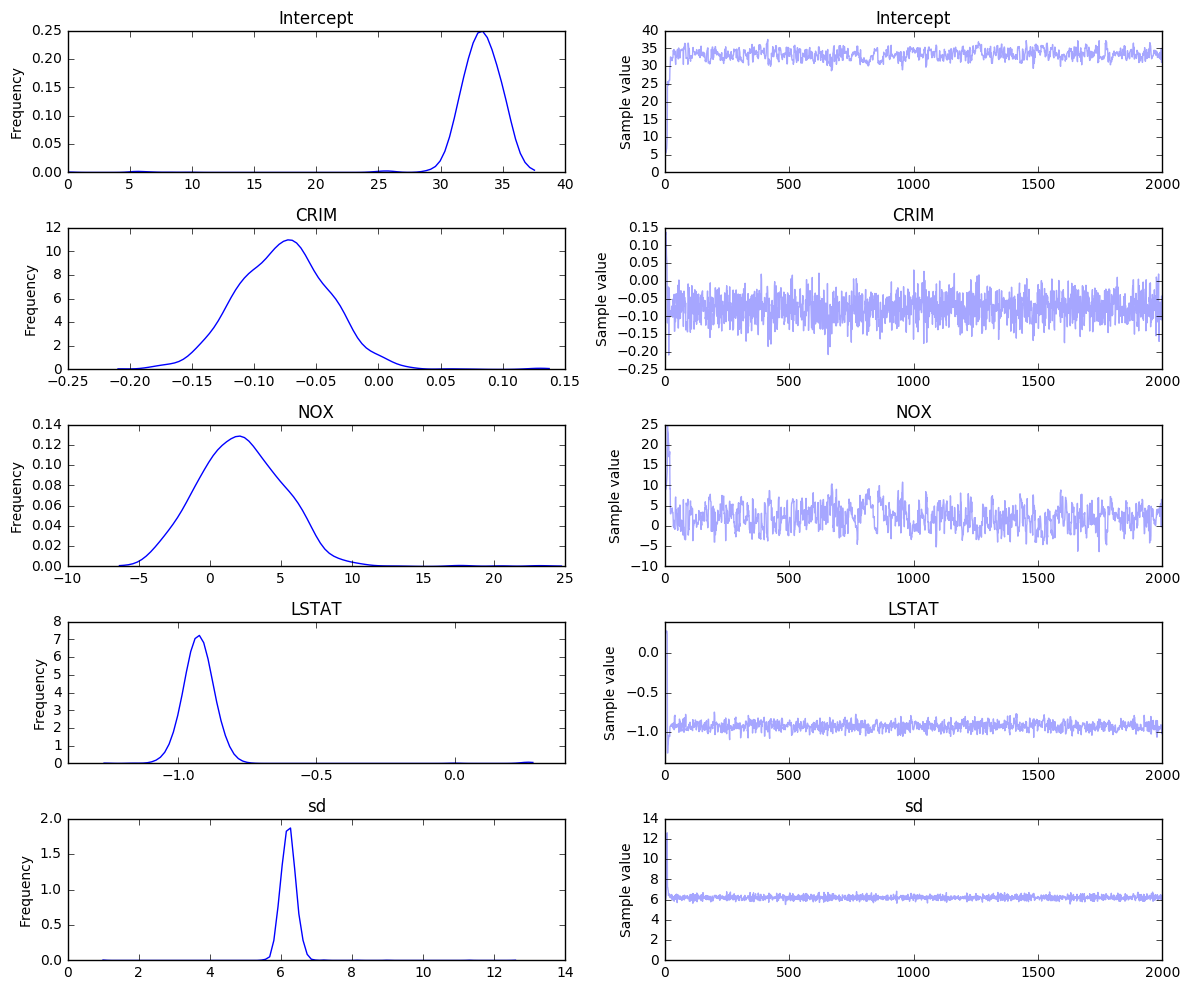

In [13]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

PyMC also offers a great summary function

In [14]:
pm.summary(trace)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  33.128           2.567            0.202            [30.735, 36.281]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  30.384         32.284         33.288         34.336         35.958


CRIM:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.076           0.038            0.001            [-0.148, -0.007]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.146         -0.102         -0.076         -0.052         -0.004


NOX:

  Mean             SD               MC Error         95% HPD interval
  ------------------

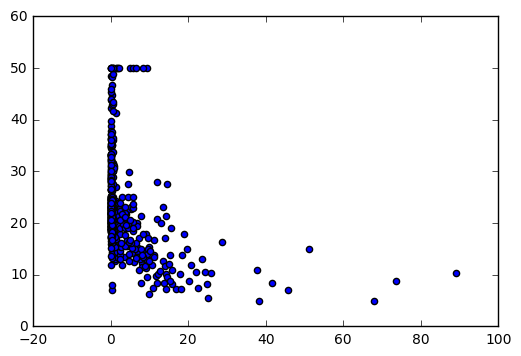

In [15]:
# Output the data to get a view of the regular data

plt.scatter(housing['CRIM'], housing['MEDV'])

Now see how our Bayes MCMC model predicts it:

(-5, 100)

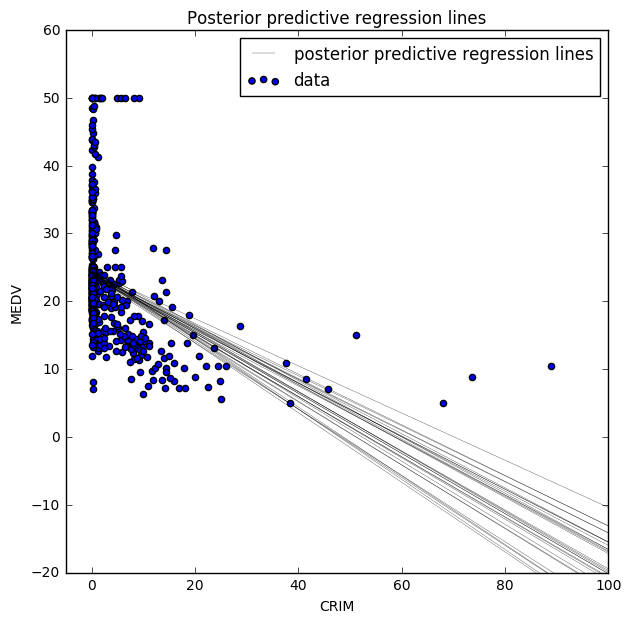

In [9]:
lm = lambda x, samp: samp['Intercept'] + samp['CRIM'] * x

plt.figure(figsize=(7, 7))
pm.glm.plot_posterior_predictive(trace, 
                                 eval=np.linspace(100, 0), # what to map the lines to (in this case, 0-100)
                                 lm=lm, # How to model the the findings -- add intercept and 'CRIM' * x for each of the 2000 runthroughs
                                 label='posterior predictive regression lines')
plt.scatter(housing['CRIM'], housing['MEDV'], label='data')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('CRIM')
plt.ylabel('MEDV')
plt.ylim(-20,60)
plt.xlim(-5, 100)

(-5, 100)

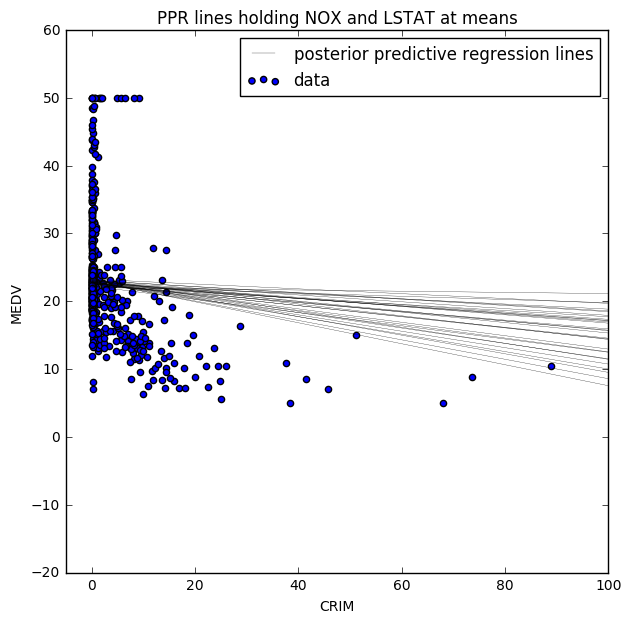

In [18]:
lm = lambda x, samp: samp['Intercept'] + samp['CRIM'] * x + samp['NOX'] * housing['NOX'].mean() + samp['LSTAT'] * housing['LSTAT'].mean()

plt.figure(figsize=(7, 7))
pm.glm.plot_posterior_predictive(trace, 
                                 eval=np.linspace(100, 0), # what to map the lines to (in this case, 0-100)
                                 lm=lm, # How to model the the findings -- add intercept and 'CRIM' * x for each of the 2000 runthroughs
                                 label='posterior predictive regression lines')
plt.scatter(housing['CRIM'], housing['MEDV'], label='data')

plt.title('PPR lines holding NOX and LSTAT at means')
plt.legend(loc=0)
plt.xlabel('CRIM')
plt.ylabel('MEDV')
plt.ylim(-20,60)
plt.xlim(-5, 100)

In [19]:
def predict_housing_values(crime_rate, nox, lstat):
    average_intercept = trace_bigger_model['Intercept'].mean()
    average_crime_coef = trace_bigger_model['CRIM'].mean()
    average_nox_coef = trace_bigger_model['NOX'].mean()
    average_lstat_coef = trace_bigger_model['LSTAT'].mean()
    return average_intercept + average_crime_coef*crime_rate + average_nox_coef*nox + average_lstat_coef*lstat

In [20]:
predict_housing_values(housing['CRIM'].mean(), housing['NOX'].mean(), housing['LSTAT'].mean())

NameError: global name 'trace_bigger_model' is not defined